In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np

# Configurar el dispositivo (GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Definir las transformaciones y cargar el dataset MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Particionar el conjunto de entrenamiento en 80% para entrenamiento y 20% para validación
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Cargar los datos
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Definir el modelo de Red Neuronal de una sola capa (SNN)
class SingleLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SingleLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = x.view(-1, 28*28)  # Aplanar la imagen de 28x28
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Definir una función para contar el número de parámetros
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Función para entrenar el modelo
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

# Función para validar el modelo
def validate(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return val_loss / len(loader), 100. * correct / total

# Entrenar el modelo con diferentes tamaños de la capa oculta y registrar los resultados
input_size = 28 * 28
num_classes = 10
hidden_sizes = [32, 64, 128, 256, 512]  # Diferentes tamaños de la capa oculta

best_model = None
best_val_acc = 0
best_hidden_size = None

results = []

for hidden_size in hidden_sizes:
    print(f"Entrenando con tamaño de capa oculta: {hidden_size}")
    model = SingleLayerNN(input_size, hidden_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 10
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate(model, val_loader, criterion)
        print(f"Época [{epoch+1}/{num_epochs}], Pérdida: {train_loss:.4f}, Precisión: {train_acc:.2f}%, Pérdida Val: {val_loss:.4f}, Precisión Val: {val_acc:.2f}%")

    num_params = count_parameters(model)
    results.append((hidden_size, num_params, val_acc))

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_hidden_size = hidden_size
        best_model = model

# Resultados
for hidden_size, num_params, val_acc in results:
    print(f"Capa oculta: {hidden_size}, Parámetros: {num_params}, Precisión Validación: {val_acc:.2f}%")

print(f"Mejor tamaño de capa oculta: {best_hidden_size}, Precisión Validación: {best_val_acc:.2f}%")

# Combinar el conjunto de entrenamiento y validación
full_train_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])

# Crear un nuevo DataLoader para entrenar el mejor modelo en el conjunto completo
full_train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True)

# Re-entrenar el mejor modelo con todo el conjunto de entrenamiento
best_model = SingleLayerNN(input_size, best_hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

# Entrenar el modelo con todo el conjunto de entrenamiento (80% + 20%)
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train(best_model, full_train_loader, criterion, optimizer)
    print(f"Época [{epoch+1}/{num_epochs}], Pérdida en entrenamiento completo: {train_loss:.4f}, Precisión: {train_acc:.2f}%")

# Finalmente, evaluar el mejor modelo en el conjunto de prueba
test_loss, test_acc = validate(best_model, test_loader, criterion)
print(f"Precisión en el conjunto de prueba: {test_acc:.2f}%")

Entrenando con tamaño de capa oculta: 32
Época [1/10], Pérdida: 0.3799, Precisión: 89.11%, Pérdida Val: 0.2424, Precisión Val: 93.02%
Época [2/10], Pérdida: 0.2094, Precisión: 93.81%, Pérdida Val: 0.1951, Precisión Val: 94.35%
Época [3/10], Pérdida: 0.1646, Precisión: 95.12%, Pérdida Val: 0.1614, Precisión Val: 95.28%
Época [4/10], Pérdida: 0.1377, Precisión: 95.92%, Pérdida Val: 0.1482, Precisión Val: 95.63%
Época [5/10], Pérdida: 0.1221, Precisión: 96.32%, Pérdida Val: 0.1443, Precisión Val: 95.62%
Época [6/10], Pérdida: 0.1086, Precisión: 96.69%, Pérdida Val: 0.1444, Precisión Val: 95.85%
Época [7/10], Pérdida: 0.0987, Precisión: 96.97%, Pérdida Val: 0.1322, Precisión Val: 96.22%
Época [8/10], Pérdida: 0.0897, Precisión: 97.31%, Pérdida Val: 0.1324, Precisión Val: 96.32%
Época [9/10], Pérdida: 0.0829, Precisión: 97.51%, Pérdida Val: 0.1329, Precisión Val: 96.14%
Época [10/10], Pérdida: 0.0779, Precisión: 97.57%, Pérdida Val: 0.1326, Precisión Val: 96.24%
Entrenando con tamaño de cap

Hidden Size 32, Epoch 1, Train Loss: 0.4352, Train Acc: 87.73%, Val Loss: 0.2648, Val Acc: 92.28%
Hidden Size 32, Epoch 2, Train Loss: 0.2248, Train Acc: 93.46%, Val Loss: 0.2064, Val Acc: 94.03%
Hidden Size 32, Epoch 3, Train Loss: 0.1737, Train Acc: 94.92%, Val Loss: 0.1801, Val Acc: 94.72%
Hidden Size 32, Epoch 4, Train Loss: 0.1439, Train Acc: 95.83%, Val Loss: 0.1584, Val Acc: 95.35%
Hidden Size 32, Epoch 5, Train Loss: 0.1242, Train Acc: 96.35%, Val Loss: 0.1455, Val Acc: 95.83%
Hidden Size 32, Epoch 6, Train Loss: 0.1103, Train Acc: 96.81%, Val Loss: 0.1388, Val Acc: 95.91%
Hidden Size 32, Epoch 7, Train Loss: 0.0986, Train Acc: 97.15%, Val Loss: 0.1381, Val Acc: 96.16%
Hidden Size 32, Epoch 8, Train Loss: 0.0887, Train Acc: 97.45%, Val Loss: 0.1297, Val Acc: 96.39%
Hidden Size 32, Epoch 9, Train Loss: 0.0813, Train Acc: 97.60%, Val Loss: 0.1321, Val Acc: 96.21%
Hidden Size 32, Epoch 10, Train Loss: 0.0747, Train Acc: 97.76%, Val Loss: 0.1275, Val Acc: 96.33%
Hidden Size 64, Epo

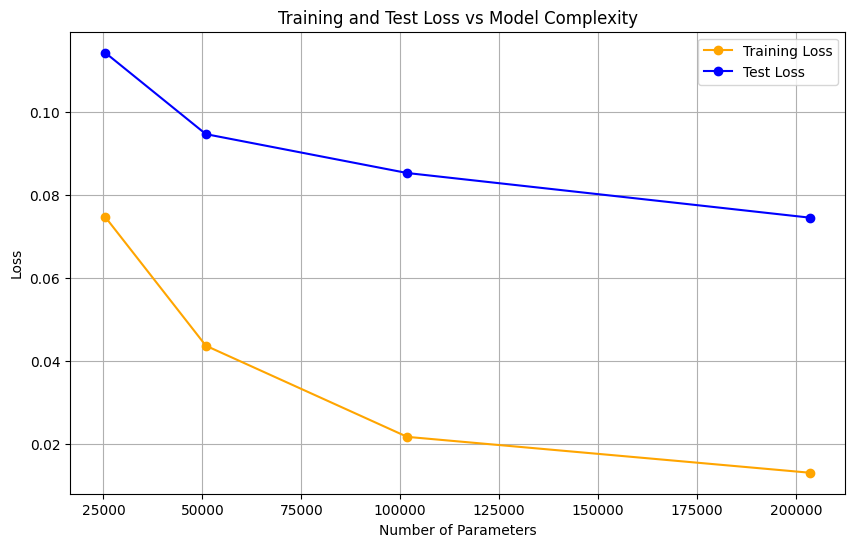

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Configurar el dispositivo (GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Definir las transformaciones y cargar el dataset MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Particionar el conjunto de entrenamiento en 80% para entrenamiento y 20% para validación
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Cargar los datos
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Definir el modelo de Red Neuronal de una sola capa (SNN)
class SingleLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SingleLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Función para entrenar el modelo
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    total_correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total_correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    avg_loss = total_loss / total
    avg_acc = 100. * total_correct / total
    return avg_loss, avg_acc

# Función para validar el modelo
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total_correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    avg_loss = total_loss / total
    avg_acc = 100. * total_correct / total
    return avg_loss, avg_acc

# Entrenar el modelo con diferentes tamaños de la capa oculta y registrar los resultados
input_size = 28 * 28
num_classes = 10
hidden_sizes = [32, 64, 128, 256]  # Diferentes tamaños de la capa oculta

best_val_loss = float('inf')
best_model = None
best_hidden_size = None

num_params_list = []
train_losses = []
test_losses = []

# Entrenar diferentes modelos con distintos tamaños de la capa oculta
for hidden_size in hidden_sizes:
    model = SingleLayerNN(input_size, hidden_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 10

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate(model, val_loader, criterion)
        print(f"Hidden Size {hidden_size}, Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Compare and update the best model if current is better
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_hidden_size = hidden_size

    # Evaluate the current model on the test set
    test_loss, test_acc = validate(model, test_loader, criterion)
    num_params = count_parameters(model)
    num_params_list.append(num_params)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Re-train the best model on the combined training and validation set
full_train_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
full_train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True)
best_model = SingleLayerNN(input_size, best_hidden_size, num_classes).to(device)
train_loss, train_acc = train(best_model, full_train_loader, criterion, optimizer)

# Evaluate the best model on the test set
test_loss, test_acc = validate(best_model, test_loader, criterion)
print(f"Best Model Hidden Size: {best_hidden_size}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

# Plot the training and test losses for all models
plt.figure(figsize=(10, 6))
plt.plot(num_params_list, train_losses, label='Training Loss', marker='o', linestyle='-', color='orange')
plt.plot(num_params_list, test_losses, label='Test Loss', marker='o', linestyle='-', color='blue')
plt.xlabel('Number of Parameters')
plt.ylabel('Loss')
plt.title('Training and Test Loss vs Model Complexity')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
print(f"Total de parámetros del mejor modelo: {count_parameters(best_model)}")

Total de parámetros del mejor modelo: 203530


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Configurar el dispositivo (GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Definir las transformaciones y cargar el dataset MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset_full = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Particionar el conjunto de entrenamiento en 80% para entrenamiento y 20% para validación
train_size = int(0.8 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

# Cargar los datos
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Definir el modelo de Red Neuronal de una sola capa (SNN)
class SingleLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SingleLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Función para entrenar el modelo
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    total_correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total_correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    avg_loss = total_loss / total
    avg_acc = 100. * total_correct / total
    return avg_loss, avg_acc

# Función para validar el modelo
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total_correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    avg_loss = total_loss / total
    avg_acc = 100. * total_correct / total
    return avg_loss, avg_acc

# Función para contar los parámetros del modelo
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Entrenar el modelo SNN con diferentes tamaños de la capa oculta y registrar los resultados
input_size = 28 * 28
num_classes = 10
hidden_sizes = [32, 64, 128, 256]  # Diferentes tamaños de la capa oculta

best_val_loss = float('inf')
best_model = None
best_hidden_size = None

num_params_list = []
train_losses = []
test_losses = []

criterion = nn.CrossEntropyLoss()

for hidden_size in hidden_sizes:
    model = SingleLayerNN(input_size, hidden_size, num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 10

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate(model, val_loader, criterion)
        print(f"SNN Hidden Size {hidden_size}, Epoch {epoch+1}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Actualizar el mejor modelo basado en la pérdida de validación
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_hidden_size = hidden_size

    # Evaluar el modelo actual en el conjunto de prueba
    test_loss, test_acc = validate(model, test_loader, criterion)
    num_params = count_parameters(model)
    num_params_list.append(num_params)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Re-entrenar el mejor modelo SNN en el conjunto completo de entrenamiento
full_train_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
full_train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True)
best_model = SingleLayerNN(input_size, best_hidden_size, num_classes).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc = train(best_model, full_train_loader, criterion, optimizer)
    print(f"Re-training SNN Hidden Size {best_hidden_size}, Epoch {epoch+1}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

# Evaluar el mejor modelo SNN en el conjunto de prueba
test_loss, test_acc = validate(best_model, test_loader, criterion)
print(f"Best SNN Hidden Size: {best_hidden_size}, "
      f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

# Graficar las pérdidas de entrenamiento y prueba vs. complejidad del modelo para SNN
plt.figure(figsize=(10, 6))
plt.plot(num_params_list, train_losses, label='Training Loss SNN', marker='o', linestyle='-', color='orange')
plt.plot(num_params_list, test_losses, label='Test Loss SNN', marker='o', linestyle='-', color='blue')
plt.xlabel('Número de Parámetros')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Prueba vs Complejidad del Modelo para SNNs')
plt.legend()
plt.grid(True)
plt.show()

# Guardar el número de parámetros del mejor modelo SNN
best_snn_num_params = count_parameters(best_model)
print(f"Best SNN Num Params: {best_snn_num_params}")

# Definir la clase MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(MLP, self).__init__()
        layers = []
        in_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.ReLU())
            in_size = hidden_size
        layers.append(nn.Linear(in_size, num_classes))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.model(x)

# Entrenar y validar los modelos MLP
mlp_configs = [
    [64, 64],
    [128, 64],
    [256, 128],
    [512, 256],
    [64, 64, 32],
    [128, 64, 32],
    [256, 128, 64],
    [512, 256, 128],
    [128, 128, 64, 32],
    [256, 128, 64, 32],
    # Agrega más configuraciones según sea necesario
]

best_val_loss = float('inf')
best_mlp_model = None
best_mlp_config = None

# Inicializar las listas para almacenar los datos
num_params_list_mlp = []
train_losses_mlp = []
test_losses_mlp = []

for hidden_sizes in mlp_configs:
    model = MLP(input_size, hidden_sizes, num_classes).to(device)
    num_params = count_parameters(model)
    
    print(f"MLP Config: {hidden_sizes}, Num Params: {num_params}")
    
    # Verificar si el número de parámetros es similar al del mejor SNN
    if abs(num_params - best_snn_num_params) > 0.3 * best_snn_num_params:
        print("Skipped due to parameter count difference.")
        continue  # Saltar configuraciones con diferencia mayor al 30%
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 10
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate(model, val_loader, criterion)
        print(f"MLP Config {hidden_sizes}, Epoch {epoch+1}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Actualizar el mejor modelo MLP basado en la pérdida de validación
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_mlp_model = model
        best_mlp_config = hidden_sizes
        best_num_params_mlp = num_params
    
    # Evaluar el modelo actual en el conjunto de prueba
    test_loss, test_acc = validate(model, test_loader, criterion)
    
    # Almacenar los datos para las gráficas
    num_params_list_mlp.append(num_params)
    train_losses_mlp.append(train_loss)
    test_losses_mlp.append(test_loss)

# Verificar si se encontró un mejor modelo MLP
if best_mlp_config is None:
    print("No se encontró una configuración MLP adecuada. Por favor, ajusta 'mlp_configs' o la tolerancia.")
else:
    print(f"Best MLP Config: {best_mlp_config}, Num Params: {best_num_params_mlp}")
    # Re-entrenar el mejor MLP y probarlo
    best_mlp_model = MLP(input_size, best_mlp_config, num_classes).to(device)
    optimizer = optim.Adam(best_mlp_model.parameters(), lr=0.001)
    num_epochs = 10
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train(best_mlp_model, full_train_loader, criterion, optimizer)
        print(f"Re-training MLP Config {best_mlp_config}, Epoch {epoch+1}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    
    test_loss, test_acc = validate(best_mlp_model, test_loader, criterion)
    print(f"Final MLP Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    # Graficar las pérdidas de entrenamiento y prueba vs. complejidad del modelo para MLP
    plt.figure(figsize=(10, 6))
    plt.plot(num_params_list_mlp, train_losses_mlp, label='Training Loss MLP', marker='o', linestyle='-', color='green')
    plt.plot(num_params_list_mlp, test_losses_mlp, label='Test Loss MLP', marker='o', linestyle='-', color='red')
    plt.xlabel('Número de Parámetros')
    plt.ylabel('Pérdida')
    plt.title('Pérdida de Entrenamiento y Prueba vs Complejidad del Modelo para MLPs')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Graficar las pérdidas de entrenamiento y prueba vs. complejidad del modelo para SNN y MLP
    plt.figure(figsize=(10, 6))
    
    # Gráficas para SNN
    plt.plot(num_params_list, train_losses, label='Training Loss SNN', marker='o', linestyle='-', color='orange')
    plt.plot(num_params_list, test_losses, label='Test Loss SNN', marker='o', linestyle='-', color='blue')
    
    # Gráficas para MLP
    plt.plot(num_params_list_mlp, train_losses_mlp, label='Training Loss MLP', marker='s', linestyle='--', color='green')
    plt.plot(num_params_list_mlp, test_losses_mlp, label='Test Loss MLP', marker='s', linestyle='--', color='red')
    
    plt.xlabel('Número de Parámetros')
    plt.ylabel('Pérdida')
    plt.title('Pérdida de Entrenamiento y Prueba vs Complejidad del Modelo para SNNs y MLPs')
    plt.legend()
    plt.grid(True)
    plt.show()